<a href="https://colab.research.google.com/github/Hugation99/PyTrochDL/blob/main/DepthCompletionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.models import resnet
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import os
%matplotlib inline

# Data Processing

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
image_path='/content/gdrive/MyDrive/master/tesis/LidarData'
class ImagePairDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_pairs = []

        # Get all subdirectories (assuming folders represent types)
        subdirs = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]

        # Validate folder structure (two subdirectories expected)
        if len(subdirs) != 2:
            raise ValueError("Expected two subdirectories for image pairs")

        # Enumerate image pairs (assuming filenames are the same)
        for filename in os.listdir(os.path.join(image_dir, subdirs[0])):
            image_a_path = os.path.join(image_dir, subdirs[0], filename)
            image_b_path = os.path.join(image_dir, subdirs[1], filename)
            self.image_pairs.append((image_a_path, image_b_path))

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        image_a_path, image_b_path = self.image_pairs[idx]

        # Load and transform images
        image_a = self.transform(Image.open(image_a_path).convert('RGB'))
        image_b = self.transform(Image.open(image_b_path).convert('RGB'))

        return image_a, image_b  # Return both images as a pair


def preprocess_image(img_path):
  transform = transforms.ToTensor()
  return transform(img)

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        preprocess_image,
        transforms.RandomHorizontalFlip()  #Augmentation for training
    ]),
    'val': transforms.Compose([
        preprocess_image
    ])
}

# Create training dataset (including both types)
train_dataset = ImagePairDataset(os.path.join(image_path, 'train'), data_transforms['train'])

# Create validation dataset (using only type B)
val_B_dataset = ImagePairDataset(os.path.join(image_path, 'val/type_B'), data_transforms['val'])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_B_dataset, batch_size=32, shuffle=False)

In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
#test data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
pwd #check directory

'/content'

In [ ]:
#create small bacth size for images (10)
train_loader=DataLoader(train_data, batch_size=10, shuffle=True)
test_loader=DataLoader(test_data, batch_size=10, shuffle=False)

In [ ]:
X_Train.shape

torch.Size([1, 28, 28])

In [ ]:
x = X_Train.view(1,1,28,28)

# Model

In [13]:
class ResBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), padding=1)
    self.batch1 = nn.BatchNorm2d(in_channels)
    self.relu1 =  nn.LeakyReLU(negative_slope=0.02,inplace=True)
    self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=(3,3), padding=1)
    self.batch2 = nn.BatchNorm2d(out_channels)
    self.relu2 = nn.LeakyReLU(negative_slope=0.02,inplace=True)

  def forward(self, X):
    shortcut=X
    X=self.conv1(X)
    X=self.batch1(X)
    X=self.relu1(X)
    X=self.conv2(X)
    X=self.batch2(X)
    X=self.relu2(shortcut+X)
    return X

In [15]:
resblock = ResBlock(64,64)
resblock

ResBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.02, inplace=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.02, inplace=True)
)

In [16]:
class DepthNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.convg = self.conv_bn_relu(in_channels=1, out_channels=48, kernel_size=3, stride=1, padding=0) #greyscale img
    self.convs = self.conv_bn_relu(1, 16, 3, 1, 0) #sparse depth

    #Encoder
    self.res1 = ResBlock(64,64)
    self.res2 = ResBlock(64,128)
    self.res3 = ResBlock(128,256)
    self.res4 = ResBlock(256,512)

    self.conv3 = nn.Conv2d(512, 512, 3, 2, 1)

    #Decoder (add dimension of skip connection)
    self.upconv1 = self.convT_bn_relu(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.upconv2 = self.convT_bn_relu(512+256, 128, 3, 2, 1, 1)
    self.upconv3 = self.convT_bn_relu(256+128, 64, 3, 2, 1, 1)
    self.upconv4 = self.convT_bn_relu(128+64, 64, 3, 2, 1, 1)
    self.upconv5 = self.convT_bn_relu(128, 64, 3, 2, 1, 1)

    self.conv4 = nn.Conv2d(128, 1, 1, 1, 0)

  def forward(self, X):
    greyscale = nn.LeakyReLU(self.convg(X['g']))
    greyscale = nn.BatchNorm2d(48)
    sparse = nn.LeakyReLU(nn.BatchNorm2d(self.convs(X['s'])))
    sparse = nn.BatchNorm2d(48)
    concat = torch.cat((greyscale,sparse),1)

    res1 = self.res1(out)
    res2 = self.res2(res1)
    res3 = self.res3(res2)
    res4 = self.res4(res3)

    conv3 = nn.LeakyReLU(nn.BatchNorm2d(self.conv3(resnet.resnet34)))

    upconv1 = self.upconv1(conv3)
    out = torch.cat((upconv1, res4),1)

    upconv2 = self.upconv2(out)
    out = torch.cat((upconv2, res3),1)

    upconv3 = self.upconv3(out)
    out = torch.cat((upconv3, res2),1)

    upconv4 = self.upconv4(out)
    out = torch.cat((upconv4, res1),1)

    upconv5 = self.upconv5(out)
    out = torch.cat((upconv5, concat),1)

    out = self.conv4(out)

    return out

  def conv_bn_relu(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
    conv_bn_relu = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )
    return conv_bn_relu

  def convT_bn_relu(self, in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0):
    convT_bn_relu = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )
    return convT_bn_relu

In [17]:
#create instance of our model
model = DepthNet()
model

DepthNet(
  (convg): Sequential(
    (0): Conv2d(1, 48, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (convs): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (res1): ResBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): LeakyReLU(negative_slope=0.02, inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): LeakyReLU(negative_slope=0.02, inplace=True)
  )
  (res2): ResBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1

# Training + testing

In [ ]:
#loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #the smaller the longer it takes

In [ ]:
import time
start_time = time.time()

# create variables to track things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#for loop of epochs
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0
  #train
  for b,(X_train, y_train) in enumerate(train_loader):
    b+=1 #start batches at 1
    y_pred = model(X_train) #get predicted values from training set
    loss = criterion(y_pred, y_train) # how off are we? compare pred to correct answers in y_train

    predicted = torch.max(y_pred.data, 1)[1] #add up num of correct preds
    batch_corr = (predicted == y_train).sum() #how many we got correct from this batch
    trn_corr += batch_corr

    #update params
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #print some results
    if b%600 == 0:
      print(f'Epoch {i} batch:{b} loss:{loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  #test
  with torch.no_grad(): #no gradient to not update weights/biases
    for b,(X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] #adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1 F=0 and sum away

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f'training took: {total/60} minutes')

Epoch 0 batch:600 loss:0.1623610556125641
Epoch 0 batch:1200 loss:0.1502392590045929
Epoch 0 batch:1800 loss:0.4744560718536377
Epoch 0 batch:2400 loss:0.14238706231117249
Epoch 0 batch:3000 loss:0.007758188061416149
Epoch 0 batch:3600 loss:0.3836284875869751
Epoch 0 batch:4200 loss:0.0038223876617848873
Epoch 0 batch:4800 loss:0.0021286322735249996
Epoch 0 batch:5400 loss:0.0569545142352581
Epoch 0 batch:6000 loss:0.00038789428072050214
Epoch 1 batch:600 loss:0.005851339548826218
Epoch 1 batch:1200 loss:0.3855525553226471
Epoch 1 batch:1800 loss:0.004819948226213455
Epoch 1 batch:2400 loss:0.003216963727027178
Epoch 1 batch:3000 loss:0.0332382395863533
Epoch 1 batch:3600 loss:0.5372857451438904
Epoch 1 batch:4200 loss:0.04561494290828705
Epoch 1 batch:4800 loss:0.0007510822033509612
Epoch 1 batch:5400 loss:0.0001173773780465126
Epoch 1 batch:6000 loss:0.14201366901397705
Epoch 2 batch:600 loss:0.023733172565698624
Epoch 2 batch:1200 loss:0.003455493599176407
Epoch 2 batch:1800 loss:0.

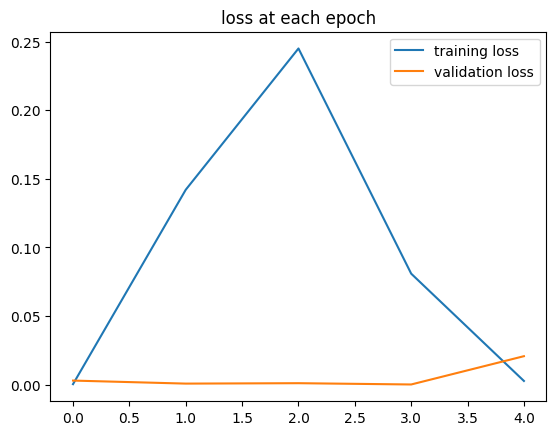

In [ ]:
#graph loss at each epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label ='training loss')
plt.plot(test_losses, label ='validation loss')
plt.title('loss at each epoch')
plt.legend()

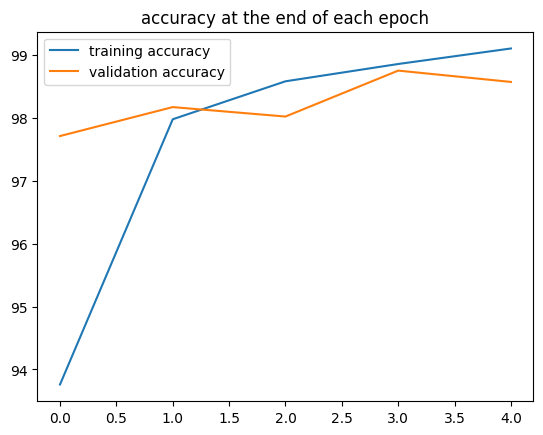

In [ ]:
#graph accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label = 'training accuracy')
plt.plot([t/100 for t in test_correct], label = 'validation accuracy')
plt.title('accuracy at the end of each epoch')
plt.legend()

In [ ]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [ ]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()

In [ ]:
#did for correct
correct.item()/len(test_data)*100

98.57000000000001

In [ ]:
test_data[4143] #tensor with image in it

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
#grab just data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [ ]:
#reshape
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

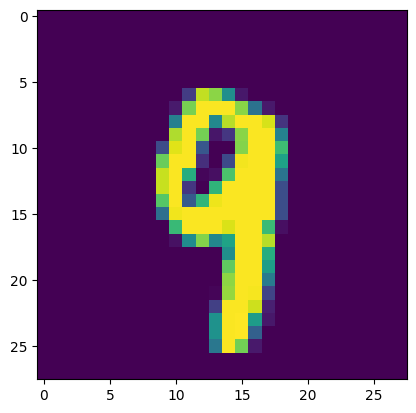

In [ ]:
plt.imshow(test_data[4143][0].reshape(28,28))

In [ ]:
#pass image trhough model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1,1,28,28)) #batch size 11, color channel 1, 28x28 img

In [ ]:
#check new pred get probabilities
new_prediction

tensor([[-2.1693e+01, -1.8584e+01, -2.1709e+01, -1.5842e+01, -8.6330e+00,
         -1.8415e+01, -3.1769e+01, -1.2734e+01, -1.3396e+01, -1.8273e-04]])

In [ ]:
new_prediction.argmax()

tensor(9)